In [38]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.feature as skft
import cv2

%matplotlib inline

In [39]:
def showImage(img, title='Output', isBGR=False, shape=(15,15)):
    fig = plt.figure(figsize=shape)
    if isBGR:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.title(title)

In [40]:
class StereoMRF(object):
    def __init__(self, dim):
        self.dimension = (16,) + dim
        self._message_field = {'DOWN': np.zeros(self.dimension, dtype=np.float32),
                               'LEFT': np.zeros(self.dimension, dtype=np.float32),
                               'UP': np.zeros(self.dimension, dtype=np.float32),
                               'RIGHT': np.zeros(self.dimension, dtype=np.float32),
                               'DATA': np.zeros(self.dimension, dtype=np.float32)}

    def _init_fields(self, img_left, img_right):
        self.reference_image = img_left.astype('float32')
        self.secondary_image = img_right.astype('float32')
        self._message_field = {'DOWN': np.zeros(self.dimension, dtype=np.float32),
                               'LEFT': np.zeros(self.dimension, dtype=np.float32),
                               'UP': np.zeros(self.dimension, dtype=np.float32),
                               'RIGHT': np.zeros(self.dimension, dtype=np.float32),
                               'DATA': np.zeros(self.dimension, dtype=np.float32)}

        for l in range(16):
            self._message_field['DATA'][l, :, l:] = np.abs(self.reference_image[:, l:] - self.secondary_image[:, :self.reference_image.shape[1] - l])

    def _update_message_fields(self):
        for direction in ['DOWN', 'LEFT', 'UP', 'RIGHT']:
            message_updates = np.sum([field for d, field in self._message_field.items() if d != direction], axis=0)
            if direction == 'DOWN':
                self._message_field[direction][:, 1:, :] = message_updates[:, :-1, :]
            elif direction == 'LEFT':
                self._message_field[direction][:, :, :-1] = message_updates[:, :, 1:]
            elif direction == 'UP':
                self._message_field[direction][:, :-1, :] = message_updates[:, 1:, :]
            elif direction == 'RIGHT':
                self._message_field[direction][:, :, 1:] = message_updates[:, :, :-1]
            norm_factor = np.max(self._message_field[direction], axis=0)[np.newaxis, :]
            norm_factor[norm_factor == 0] = 1.
            self._message_field[direction] /= norm_factor

    def _update_belief_field(self):
        energy_field = np.sum([field for d, field in self._message_field.items()], axis=0)
        self._belief_field = np.argmin(energy_field, axis=0)

    def loop_belief(self, img_left, img_right):
        self._init_fields(img_left, img_right)
        for i in range(10):
            self._update_message_fields()

    def get_map_belief(self):
        self._update_belief_field()
        return self._belief_field

    def lbp(self, img_left, img_right):
        self.loop_belief(img_left, img_right)
        return self.get_map_belief()

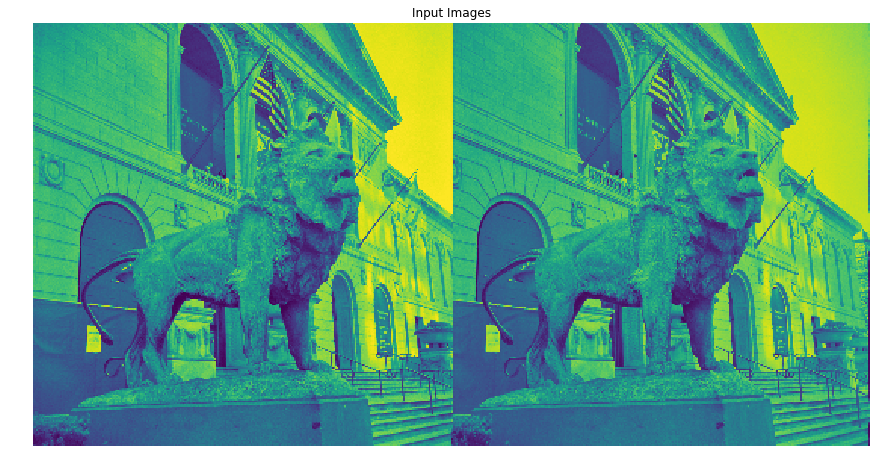

In [41]:
img = skio.imread("./Stereo Images/Stereo_Pair1.jpg", as_gray=True)
img = cv2.resize(img, None, fx=0.2, fy=0.2)
img_left = img[:,:(img.shape[1]//2)]
img_right = img[:,(img.shape[1]//2):]
showImage(img, 'Input Images')

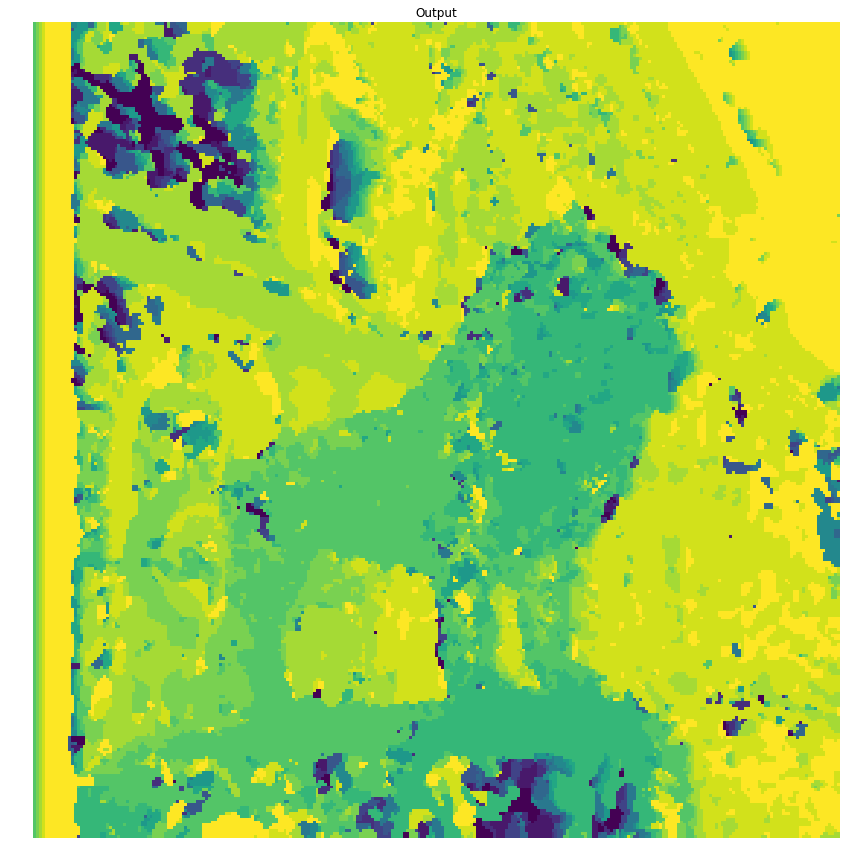

In [42]:
img_res = img_left.shape
mrf = StereoMRF(img_res)
disp_map = mrf.lbp(img_left, img_right)
showImage(disp_map)

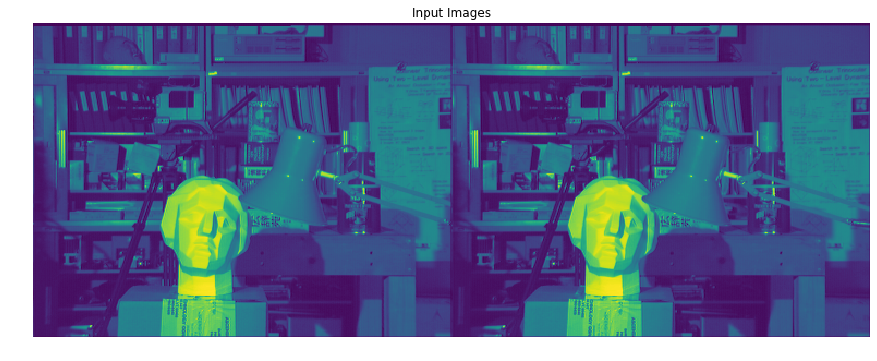

In [43]:
img_left = skio.imread('./Stereo Images/tsukuba_l.png', as_gray=True)
img_right = skio.imread('./Stereo Images/tsukuba_r.png', as_gray=True)
showImage(np.hstack([img_left, img_right]), 'Input Images')

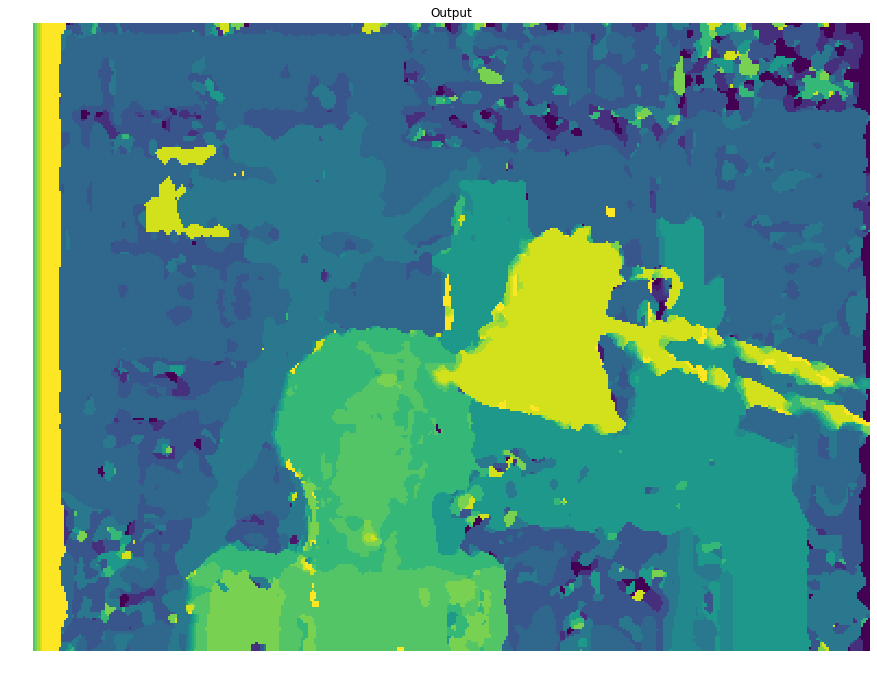

In [44]:
img_res = img_left.shape
mrf = StereoMRF(img_res)
disp_map = mrf.lbp(img_left, img_right)
showImage(disp_map)